In [1]:
from deep_traffic_generation.tcvae import TCVAE
from deep_traffic_generation.VAE_Generation import SingleStageVAE
from traffic.algorithms.generation import Generation
from deep_traffic_generation.core.datasets import TrafficDataset

from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from os import walk

# Dataset

In [2]:
dataset = TrafficDataset.from_file(
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl",
    # "../../deep_traffic_generation/data/traffic_162-216_noga_tilFAF.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

test = TrafficDataset.from_file(
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_test.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    # scaler=MinMaxScaler(feature_range=(-1,1)),
    scaler=dataset.scaler,
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

# Real Traffic

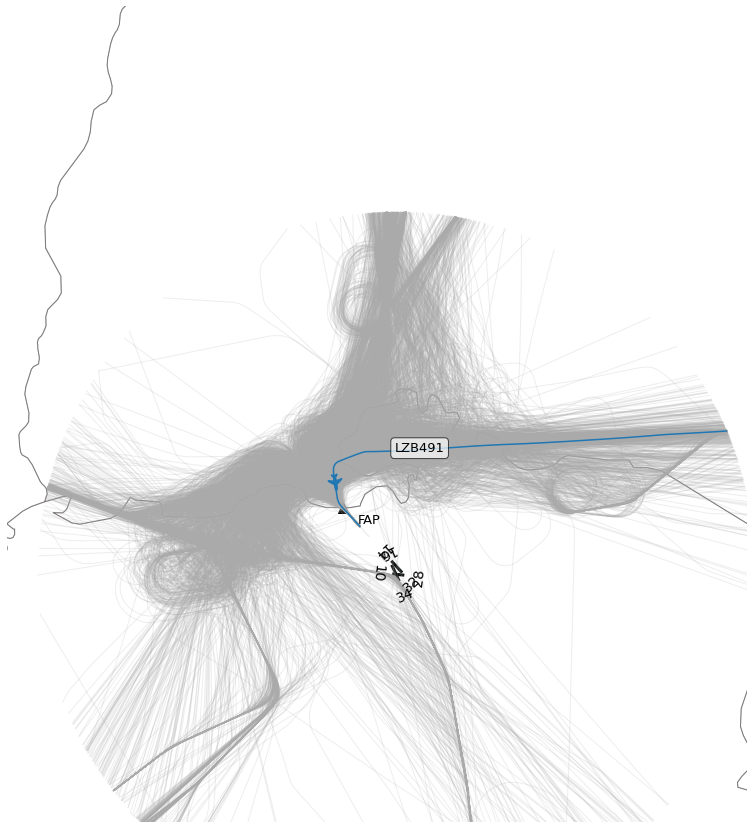

In [6]:
from traffic.core import Traffic
import matplotlib.pyplot as plt
from traffic.core.projection import EuroPP
from traffic.drawing import countries
from traffic.data import navaids
from traffic.data import airports
traffic = Traffic.from_file("../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl") 
# traffic = Traffic.from_file("../../deep_traffic_generation/data/traffic_162-216_noga_tilFAF.pkl") 
# traffic = traffic.query("not simple")


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((7.5, 9.5, 47, 48.5))

    traffic[:4000].plot(ax, alpha=0.2)

    k =  np.random.randint(len(traffic))
    traffic[k].plot(ax, color="#1f77b4", lw=1.5)
    traffic[k].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )
    
    navaids["OSNEM"].plot(
        ax,
        zorder=2,
        marker="^",
        shift=dict(units="dots", x=15, y=-15),
        text_kw={
            "s": "FAP",
        },
    )

In [7]:
dataset.parameters

{'features': ['track', 'groundspeed', 'altitude', 'timedelta'],
 'file_path': PosixPath('../../deep_traffic_generation/data/traffic_noga_tilFAF_train_enriched.pkl'),
 'info_params': {'features': ['latitude', 'longitude'], 'index': -1},
 'input_dim': 4,
 'scaler': MinMaxScaler(feature_range=(-1, 1)),
 'seq_len': 200,
 'shape': 'image'}

# Plot Generation

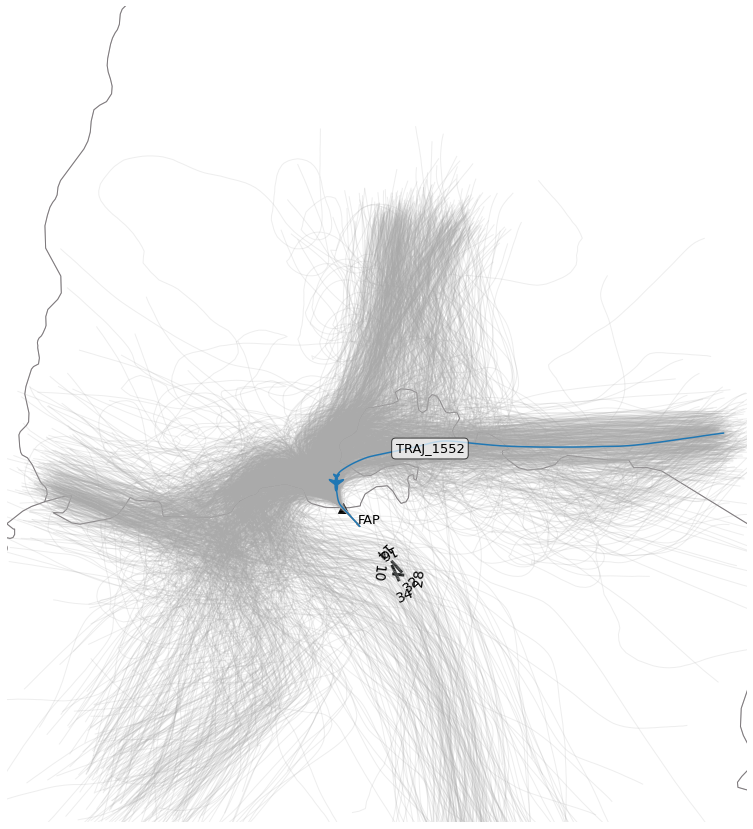

In [5]:
import matplotlib.pyplot as plt
from traffic.core.projection import EuroPP
from traffic.drawing import countries
from traffic.data import navaids
from traffic.data import airports

path = "../../deep_traffic_generation/lightning_logs/tcvae/version_24/"

t = SingleStageVAE(X = dataset, sim_type = "generation")
t.load(path, dataset.parameters)
g = Generation(generation=t, features = t.VAE.hparams.features, scaler=dataset.scaler) #scaler of the first stage (the global scaler)

# t = SingleStageVAE(X = test, sim_type = "reconstruction")
# t.load(path, test.parameters)
# g = Generation(generation=t, features = t.VAE.hparams.features, scaler=test.scaler) #scaler of the first stage (the global scaler)


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((7.5, 9.5, 47, 48.5))

    traf = g.sample(2000, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False) #coordinates sont les coordonnées du dernier point car forward = False
    traf.plot(ax, alpha=0.2)

    k =  np.random.randint(len(traf))
    # k = 9720
    traf[k].plot(ax, color="#1f77b4", lw=1.5)
    traf[k].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )
    
    navaids["OSNEM"].plot(
        ax,
        zorder=2,
        marker="^",
        shift=dict(units="dots", x=15, y=-15),
        text_kw={
            "s": "FAP",
        },
    )

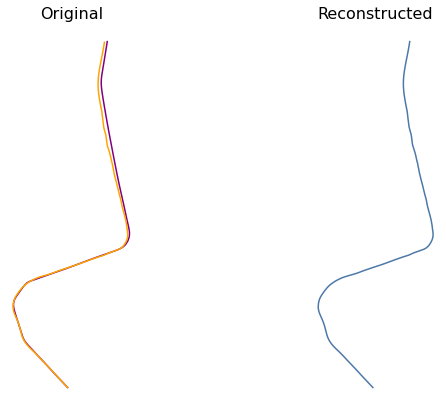

In [9]:
#Reconstruction d'une seule trajectoire
#boucle dans test : 135


j = np.random.randint(len(traf))
# j=135

original = dataset.data[j].unsqueeze(0)
# original = test.data[j].unsqueeze(0)
original = original.transpose(1,2).reshape((original.shape[0], -1))
original = dataset.scaler.inverse_transform(original)
# original = test.scaler.inverse_transform(original)
original_traf = g.build_traffic(original, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Original")
    original_traf.plot(ax[0], c="purple", label="Existing")
    traf["TRAJ_"+str(j)].plot(ax[0], c="orange", label = "Reconstructed")
    ax[1].set_title("Reconstructed")
    traf["TRAJ_"+str(j)].plot(ax[1], label = "Reconstructed")


    plt.show()


Identifier un cluster dans l'espace latent, fitter une gaussienne par dessus, et regénérer une traj

# Latent Space

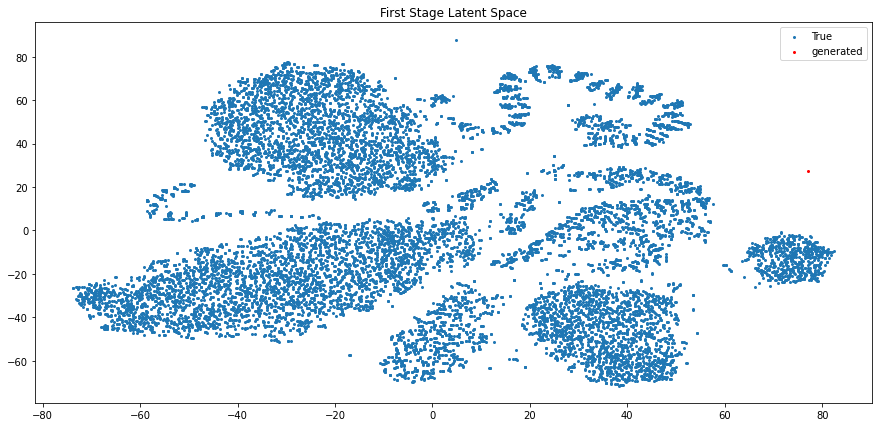

In [17]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

#latent spaces of the single stage VAE, and N generated points within (the last N rows of the array)
#plot latent representation of the dataset used to initialized the SingleStageVAE object
n_gen = 1
Z = t.latent_space(n_gen)

Z_embedded = TSNE(n_components=2).fit_transform(Z)

fig, ax = plt.subplots(1, figsize=(15, 7))
ax.scatter(Z_embedded[:-n_gen, 0], Z_embedded[:-n_gen, 1], s=4, label = "True")
ax.scatter(Z_embedded[-n_gen:, 0], Z_embedded[-n_gen:, 1], s=4, c='red', label = "generated")
ax.title.set_text("First Stage Latent Space")
ax.legend()
plt.show()

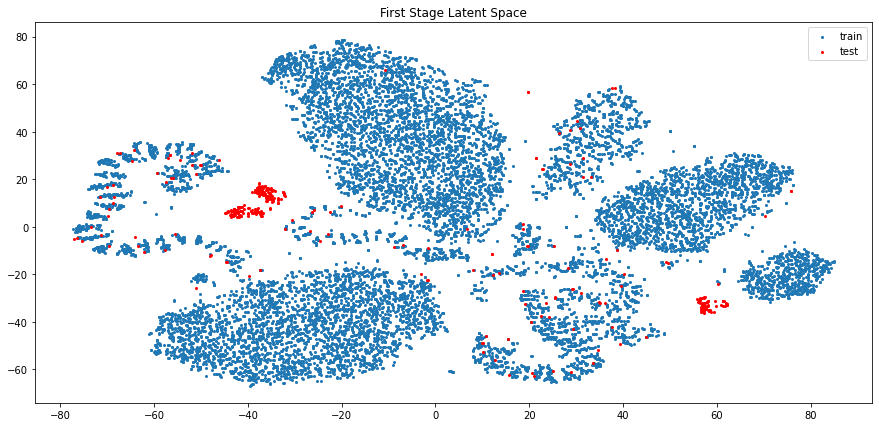

In [18]:
#latent spaces from train and test datasets

#train 
h_train = t.VAE.encoder(dataset.data)
q_train = t.VAE.lsr(h_train)
z_train = q_train.rsample()
z_train = z_train.detach().numpy()

#test 
h_test = t.VAE.encoder(test.data)
q_test = t.VAE.lsr(h_test)
z_test = q_test.rsample()
z_test = z_test.detach().numpy()

Z = np.concatenate((z_train, z_test), axis=0)
Z_embedded = TSNE(n_components=2).fit_transform(Z)

fig, ax = plt.subplots(1, figsize=(15, 7))
ax.scatter(Z_embedded[:-len(test), 0], Z_embedded[:-len(test), 1], s=4, label = "train")
ax.scatter(Z_embedded[-len(test):, 0], Z_embedded[-len(test):, 1], s=4, c='red', label = "test")
ax.title.set_text("First Stage Latent Space")
ax.legend()
plt.show()

In [24]:
# Are the latent means really next to the ring of standard gaussian in dimension 256 ?

quant = 3.69 #comme c'est 2 sided ca va nous donner une proba a 0.9998 alors que c'est le quantile 0.9999
up = np.sqrt(t.VAE.lsr.out_dim) + quant/np.sqrt(2)
down = np.sqrt(t.VAE.lsr.out_dim) - quant/np.sqrt(2)
print("range of norms : ", down, up)

#parameters of latent space distributions
h = t.VAE.encoder(dataset.data)
# h = t.VAE.encoder(test.data)
q = t.VAE.lsr(h)
params = t.VAE.lsr.dist_params(q)
means_norms = np.linalg.norm(params[1].detach().numpy()[:,0,:], ord = 2, axis = 1)
mask = (means_norms < up) & (means_norms > down)
print("proportion of means well located for a standard gaussian :", mask.sum()/len(mask))
print("quantiles 0.25, 0.5 and 0.75 of means : ", np.quantile(means_norms, [0.25, 0.5, 0.75]))

#NOPE
#Il y en a plus proche de 0, et certains plus loins, mais peu dans la bonne fenetre
#En dimension 256 tout est très dilaté, et donc l'espace est trop grand 


range of norms :  13.39077597742164 18.60922402257836
proportion of means well located for a standard gaussian : 0.07457142857142857
quantiles 0.25, 0.5 and 0.75 of means :  [ 8.05562162  9.58656454 18.88612127]


In [8]:
#empirical propability within the bounds of the posteriori distribution 
mix = torch.distributions.Categorical(torch.ones(len(dataset.data),))
comp = torch.distributions.Independent(torch.distributions.Normal(params[1][:,0,:], params[2][:,0,:]), 1)
gmm = torch.distributions.mixture_same_family.MixtureSameFamily(mix, comp)
z = gmm.sample(sample_shape=torch.Size([10000]))

z_norms = np.linalg.norm(z.detach().numpy(), ord = 2, axis = 1)
z_mask = (z_norms < up) & (z_norms > down)
print("proportion of points from the posteriori between the bounds : ", z_mask.sum()/len(z_mask))

proportion of points from the posteriori between the bounds :  0.077


In [9]:
#Empirical validation of the bounds
p = torch.distributions.Normal(torch.zeros(t.VAE.lsr.out_dim), torch.ones(t.VAE.lsr.out_dim))
u = p.rsample((100000,))

u_norms = np.linalg.norm(u.detach().numpy(), ord = 2, axis = 1)
u_mask = (u_norms < up) & (u_norms > down)
print("proportion of points from a standard gaussian located between the bounds : ", u_mask.sum()/len(u_mask))

proportion of points from a standard gaussian located between the bounds :  0.99977


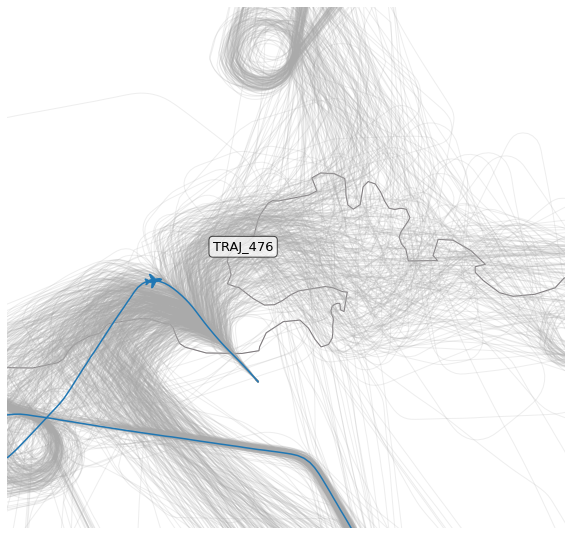

In [10]:
#Trajectories well located
goods = params[1][np.where(mask == True)[0],0,:]

out = t.decode(torch.tensor(goods))
out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((8, 9, 47.37, 48))
    out_traf.plot(ax, alpha=0.2)

    k =  np.random.randint(len(out_traf))
    out_traf[k].plot(ax, color="#1f77b4", lw=1.5)
    out_traf[k].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

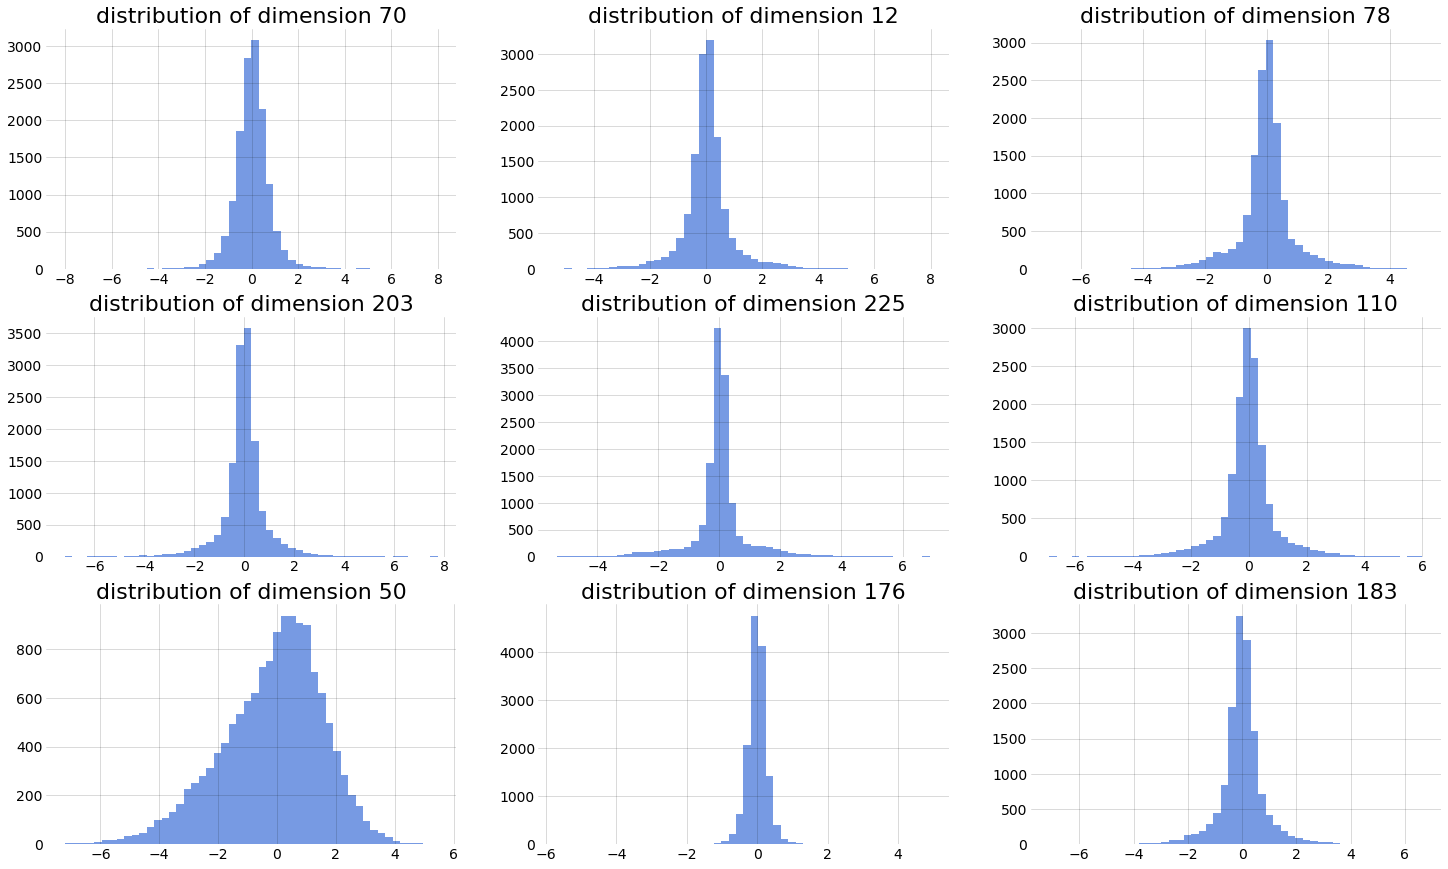

In [11]:
#Are each dimension normally distributed ? plot the histogram of each of 256 dimensions
#C'est une condition nécessaire mais pas suffisante right ?

with plt.style.context("traffic"):
    fig, ax = plt.subplots(3, 3, figsize=(25, 15))
    for i in np.arange(0,3):
        for j in np.arange(0,3):
            k = np.random.randint(0, t.VAE.lsr.out_dim)
            ax[i,j].hist(params[1][:,0,k].detach().numpy(), bins = 50)
            ax[i,j].title.set_text("distribution of dimension "+str(k))
    

In [12]:
from scipy.stats import kstest

#testing the normality of the distribution of the means along each dimension
#p_value = proba to abserve a most extreme value than the one observed with the stat under the null hypothesis
#low p_value -> reject null
p_values = []

for i in range(t.VAE.lsr.out_dim):
    stat, p_value = kstest(params[1][:,0,i].detach().numpy(), "norm")
    p_values.append(p_value)

print("Greatest p_value for the normality test :", np.max(p_values))
#despite the histograms, none of the dimensions are normaly distributed

Greatest p_value for the normality test : 1.1780018739547312e-16


# Analysis of the dimensions and their variances within the latent space

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

#latent spaces of the single stage VAE, and 100 generated points within (the last 100 rows of the array)
n_gen = 0
Z = t.latent_space(n_gen)

kmeans = KMeans(n_clusters=5, random_state=0).fit(Z)

Z_embedded = TSNE(n_components=2).fit_transform(Z)

fig, ax = plt.subplots(1, figsize=(15, 7))
ax.scatter(Z_embedded[:, 0], Z_embedded[:, 1], s=4, c=kmeans.labels_.astype(float))
ax.title.set_text("First Stage Latent Space")
ax.legend()
plt.show()

In [18]:
a = np.where(kmeans.labels_ == 0)[0]
print(len(a))

1227


In [19]:
original = dataset.data[a]
original = original.transpose(1,2).reshape((original.shape[0], -1))
original = dataset.scaler.inverse_transform(original)
original_traf = g.build_traffic(original, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

original_traf

,count
flight_id,
TRAJ_0,200
TRAJ_628,200
TRAJ_634,200
TRAJ_633,200
TRAJ_632,200
TRAJ_631,200
TRAJ_630,200
TRAJ_63,200
TRAJ_629,200


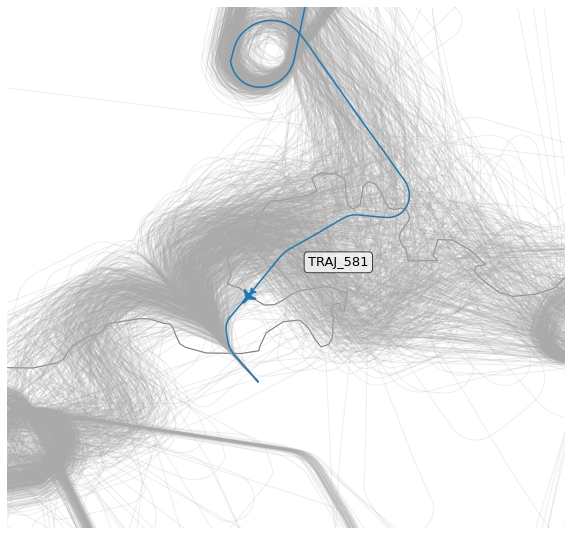

In [20]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((8, 9, 47.37, 48))
    original_traf.plot(ax, alpha=0.2)

    # k =  np.random.randint(len(original_traf))
    # k = 813
    # k = 782
    k = 763
    original_traf[k].plot(ax, color="#1f77b4", lw=1.5)
    original_traf[k].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )


In [22]:
#une trajectoire avec holding
a[581]

7283

In [23]:
#distributions of go-arounds within latent space
h = t.VAE.encoder(dataset.data)
q = t.VAE.lsr(h)
params = t.VAE.lsr.dist_params(q)

In [24]:
mu = params[1][7283]
sigma = params[2][7283]

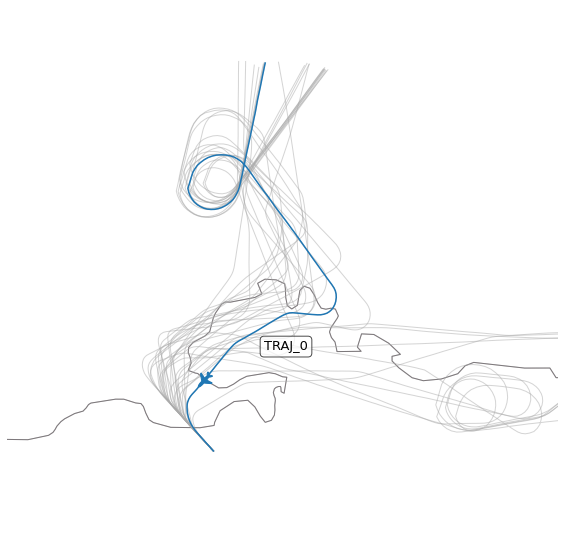

In [25]:
#Points les plus proches dans l'espace latent de la trajectoire 7936
dists = []

for m in range(params[1].shape[0]):
    dists.append(np.linalg.norm(mu.detach().numpy() - params[1][m].detach().numpy()))

np.argsort(dists)

out = t.decode(params[1][np.argsort(dists)[:30]][:,0,:])
out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, figsize=(15, 10), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((8, 9.2, 47.4, 48.2))
    out_traf.plot(ax, alpha=0.5)

    # k =  np.random.randint(len(out_traf))
    k = 0
    out_traf[k].plot(ax, color="#1f77b4", lw=1.5)
    out_traf[k].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

In [100]:
#On met une petit variance qu'aux dimensions les plus importantes de l'espace latent
sigma_constructed = torch.ones(256)*5
sigma_constructed[np.argsort(sigma.detach().numpy())[0][:128]] = 0.0001

In [208]:
sigma_constructed = torch.ones(256)*0.0001
sigma_constructed[np.argsort(sigma.detach().numpy())[0][75]] = 1

In [209]:
#On génère dans une normale centrée sur le cluster des go arounds
#Plus on augmente sigma, plus la reconstruction devient blurry
p = torch.distributions.Normal(mu, sigma_constructed)
# p = torch.distributions.Normal(params[1][6908], 50*params[2][6908])
u = p.rsample((10,))

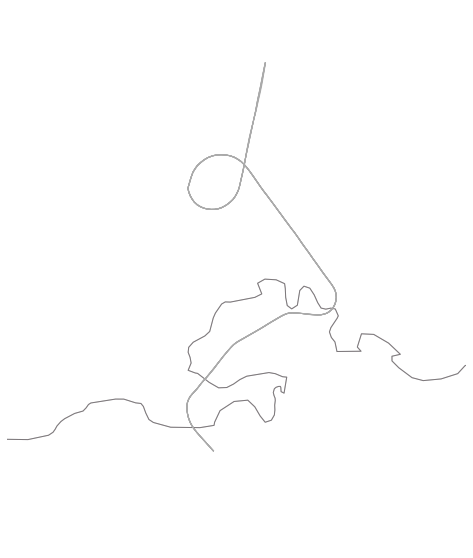

In [210]:
out = t.decode(u[:,0,:])
out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, figsize=(15, 10), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((8, 9, 47.4, 48.2))
    out_traf.plot(ax, alpha=0.8)

# Are the most important dimensions de same for every trajectory ?

In [34]:
h = t.VAE.encoder(dataset.data)
q = t.VAE.lsr(h)
params = t.VAE.lsr.dist_params(q)

In [35]:
import random
rd = random.sample(range(len(dataset.data)), 10000)
# rd =[5678, 7371, 8115, 792, 12899, 1038, 12221, 13897, 845, 6058]

original = dataset.data[rd]
original = original.transpose(1,2).reshape((original.shape[0], -1))
original = dataset.scaler.inverse_transform(original)
original_traf = g.build_traffic(original, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

# with plt.style.context("traffic"):
#     fig, ax = plt.subplots(1, subplot_kw=dict(projection=EuroPP()))
#     ax.set_title("Selected")
#     original_traf.plot(ax)

In [36]:
scales = params[2][rd,0,:].detach().numpy()
nb_idx = 50
argsorted = np.zeros((len(rd), nb_idx))

for i in range(len(rd)):
    argsorted[i,:] = np.argsort(scales[i])[:nb_idx]
    # print(argsorted[i,:])

In [37]:
import collections

print("Indexes that appears within the nost important dimensions:")
print(collections.Counter(argsorted.flatten()), "\n")

for i in range(argsorted.shape[1]):
    col = collections.Counter(argsorted[:,i])
    print("most common id of col ",i," : ", col.most_common(1)[0][0], " with a rate of appearance of ", col.most_common(1)[0][1]/argsorted.shape[0])

Indexes that appears within the nost important dimensions:
Counter({166.0: 10000, 93.0: 10000, 109.0: 10000, 17.0: 10000, 67.0: 10000, 122.0: 10000, 203.0: 10000, 227.0: 10000, 205.0: 10000, 59.0: 10000, 97.0: 10000, 55.0: 10000, 233.0: 10000, 45.0: 10000, 208.0: 10000, 96.0: 10000, 0.0: 10000, 147.0: 10000, 169.0: 10000, 190.0: 10000, 160.0: 10000, 174.0: 10000, 28.0: 10000, 105.0: 10000, 69.0: 10000, 13.0: 10000, 250.0: 10000, 155.0: 10000, 138.0: 10000, 39.0: 10000, 253.0: 10000, 249.0: 10000, 214.0: 10000, 12.0: 10000, 176.0: 10000, 1.0: 10000, 244.0: 10000, 44.0: 10000, 32.0: 10000, 66.0: 10000, 143.0: 9999, 242.0: 9998, 181.0: 9998, 4.0: 9996, 88.0: 9958, 61.0: 9792, 164.0: 8664, 163.0: 8566, 161.0: 8284, 65.0: 7651, 72.0: 3979, 158.0: 881, 188.0: 697, 225.0: 556, 201.0: 345, 103.0: 339, 117.0: 136, 120.0: 129, 241.0: 9, 68.0: 8, 71.0: 7, 30.0: 5, 224.0: 2, 124.0: 1}) 

most common id of col  0  :  166.0  with a rate of appearance of  0.5866
most common id of col  1  :  93.0  wit

# Generated trajectories build with a combination of latent space elements

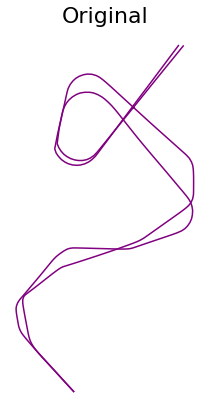

In [182]:
original = dataset.data[[7936, 12899]]
original = original.transpose(1,2).reshape((original.shape[0], -1))
original = dataset.scaler.inverse_transform(original)
original_traf = g.build_traffic(original, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, subplot_kw=dict(projection=EuroPP()))
    ax.set_title("Original")
    original_traf.plot(ax, c="purple", label="Existing")

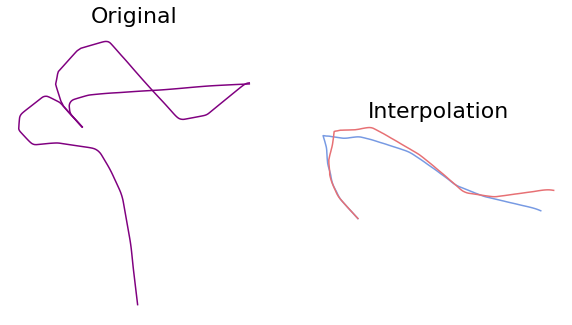

In [17]:
i = np.random.randint(len(dataset))
j = np.random.randint(len(dataset))
k = np.random.randint(len(dataset))

z1 = Z[i]
z2 = Z[j]
z3 = Z[k]
lambdas = list(np.linspace(0,1,10))
z_inter = []

# for lam in lambdas:
#     z_inter.append(lam*z1 + (1-lam)*z2)

# z_inter = np.array(z_inter)

z_inter = np.array([(1/3)*z1 + (1/3)*z2 + (1/3)*z3, 0.2*z1 + 0.6*z2 + 0.2*z3])


out = t.decode(torch.tensor(z_inter))
out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

# original = dataset.data[[i,j]]
original = dataset.data[[i,j,k]]
original = original.transpose(1,2).reshape((original.shape[0], -1))
original = dataset.scaler.inverse_transform(original)
original_traf = g.build_traffic(original, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)



# with plt.style.context("traffic"):
#     fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
#     ax[0].set_title("Original")
#     out_traf[0].plot(ax[0], c="orange", label="Existing reconstructed")
#     out_traf[9].plot(ax[0], c="orange", label="Existing reconstructed")
#     original_traf.plot(ax[0], c="purple", label="Existing")
#     ax[1].set_title("Interpolation")
#     out_traf[0].plot(ax[1], c = "royalblue", label = "reconstructed")
#     out_traf[9].plot(ax[1], c = "royalblue", label = "reconstructed")
#     out_traf[1:9].plot(ax[1], label = "interpolated")


#     plt.show()

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Original")
    original_traf.plot(ax[0], c="purple", label="Existing")
    ax[1].set_title("Interpolation")
    out_traf.plot(ax[1], label = "interpolated")


    plt.show()


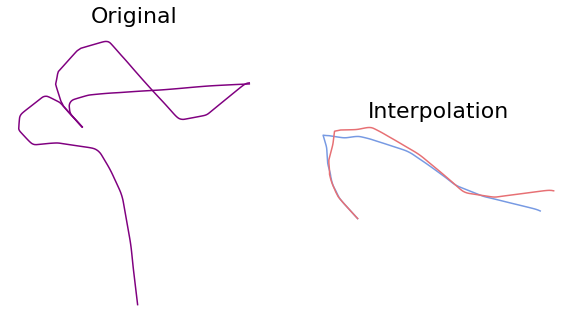

In [18]:
#same combination but directly on original trajectories

original = dataset.data[[i,j,k]]
original = original.transpose(1,2).reshape((original.shape[0], -1))
original = dataset.scaler.inverse_transform(original)
original_traf = g.build_traffic(original, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

out = np.array([(1/3)*original[0] + (1/3)*original[1] + (1/3)*original[2], 0.2*original[0] + 0.6*original[1] + 0.2*original[2]])

out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)


#     plt.show()

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Original")
    original_traf.plot(ax[0], c="purple", label="Existing")
    ax[1].set_title("Interpolation")
    out_traf.plot(ax[1], label = "interpolated")


    plt.show()
